# Insurance Data

The goal of this notebook is to retrieve, clean, and preproces insurance data, based on the following data sources.
- ZIP Code-level breakdowns of new, renewed, and non-renewal data for 2015-2021 (https://www.insurance.ca.gov/01-consumers/200-wrr/DataAnalysisOnWildfiresAndInsurance.cfm)
- Residential Property Coverage Amounts, Wildfire Risk, and Losses for 2018-2023 (https://www.insurance.ca.gov/01-consumers/200-wrr/WildfireRiskInfoRpt.cfm)
- FAIR Plan insured units for 2022 (https://www.insurance.ca.gov/01-consumers/200-wrr/DataAnalysisOnWildfiresAndInsurance.cfm)

Additionally, the notebook also used the dataset "CA Zip Code Boundaries" (https://gis.data.ca.gov/datasets/ca-zip-code-boundaries/) for mapping and EDA.

In [2]:
# # Install GeoPandas package to deal with geospatial data and map
# !conda install geopandas
# # or
# !conda install -c conda-forge geopandas

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
RAW_DATA_DIR = Path('../raw_data/')
DATA_DIR = Path('../data/')

## Zipcodes

Loading and prepocessing geospatial data on zipcodes (zipcode, population, and pop density) for EDA.

In [9]:
zipcodes = gpd.read_file(RAW_DATA_DIR / 'USA_ZIP_Code_Areas.geojson')
zipcodes.shape

(1778, 8)

In [10]:
zipcodes.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,POP_SQMI,SQMI,geometry
0,12,00012,Mt Meadows Area,CA,0.0,0.00,30.92,"POLYGON ((-13474731.772 4903282.532, -13474716..."
1,16,00016,Sequoia National Forest,CA,26.0,0.66,39.33,"POLYGON ((-13189602.036 4239987.11, -13189590...."
2,17,00017,Northeast Fresno County,CA,0.0,0.00,564.41,"POLYGON ((-13267161.108 4503250.18, -13267159...."
3,18,00018,Los Padres Ntl Forest,CA,0.0,0.00,90.83,"POLYGON ((-13255913.164 4096587.096, -13255912..."
4,19,00019,Lassen Ntl Forest,CA,17.0,0.04,412.59,"POLYGON ((-13398996.781 4949420.395, -13398824..."


In [11]:
# removing zipcodes where the population == 0
zipcodes = zipcodes[zipcodes['POPULATION'] > 0]

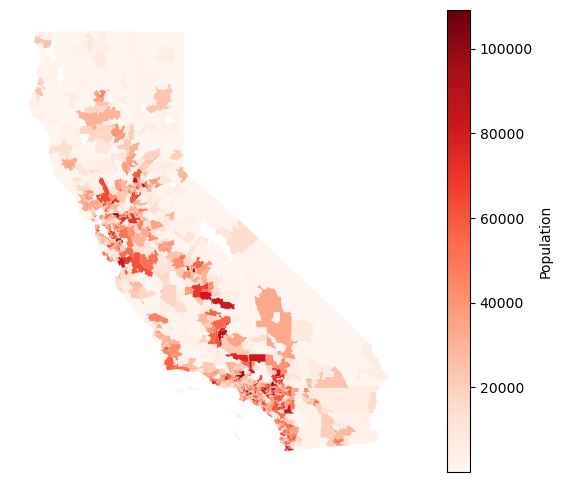

In [12]:
ax = zipcodes.plot(column='POPULATION',
                   cmap='Reds',
                   figsize=(10, 6),
                   legend=True,
                   legend_kwds={'label': 'Population'},
                   ax=None)

ax.set_axis_off();

In [13]:
zipcodes.rename(columns={'ZIP_CODE': 'ZIP Code'}, inplace=True)

In [14]:
zipcodes.to_file(DATA_DIR / 'CA_zipcodes.geojson')

## Renewals (2015-2021)

CA releases annual counts of renewals of residential policies. We use the dataset for 2015-2021 as it indicates wheter non-rewenals were initiated for by insurance companies or homeowners. (The data for 2020-2023 doesn't make this distinction.) The code below cleans the data and add new features that will be explored in EDA and potentially incorporated into our final model.

In [19]:
renewals = pd.read_excel(RAW_DATA_DIR / 'Residential-Property-Voluntary-Market-New-Renew-NonRenew-by-ZIP-2015-2021.xlsx',
                          dtype={'ZIP Code': str})
renewals.head()

,County,ZIP Code,Year,New,Renewed,Insured-Initiated Nonrenewed,Insurer-Initiated Nonrenewed
0,Los Angeles,90001,2015,734,5092,415,178
1,Los Angeles,90002,2015,807,5006,472,198
2,Los Angeles,90003,2015,1033,6115,612,305
3,Los Angeles,90004,2015,527,3875,400,128
4,Los Angeles,90005,2015,130,859,113,42


In [20]:
renewals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15538 entries, 0 to 15537
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   County                        14821 non-null  object
 1   ZIP Code                      15538 non-null  object
 2   Year                          15538 non-null  int64 
 3   New                           15538 non-null  int64 
 4   Renewed                       15538 non-null  int64 
 5   Insured-Initiated Nonrenewed  15538 non-null  int64 
 6   Insurer-Initiated Nonrenewed  15538 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 849.9+ KB


In [21]:
# removing zipcodes that aren't associated with a county
renewals = renewals[renewals['County'].isnull() == False]

<Axes: >

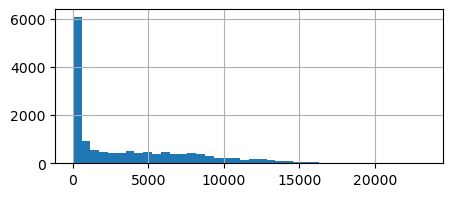

In [22]:
# removing zipcodes with very few renewals 

# The assumption here is that these zipcodes with few policies are associated with non-residential entities, 
# such as hospitals, college campuses, etc. Therefore, they are not covered by "regular" policies (i.e., a 
# homeowner contracts a insurance policy from a company).

renewals['Renewed'].hist(bins=40, figsize=(5,2))

<Axes: >

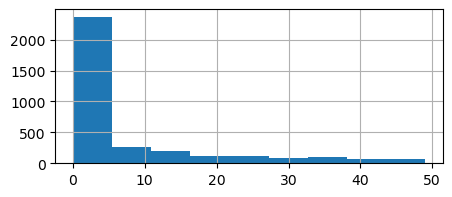

In [23]:
renewals[renewals['Renewed'] < 50].Renewed.hist(bins=9, figsize=(5,2))

In [24]:
# removing  Zipcodes while less the N renewals
n = 30
renewals = renewals[renewals['Renewed'] >= n]

### Added features

Since the dataset has the raw counts of policies (non-)renewals, we can add new features with their proportions.

In [25]:
# Renewal percentages

# number of policies about to expired (Expiring = Renewed + Nonrenewed)
renewals['Expiring'] = renewals['Renewed'] + renewals['Insured-Initiated Nonrenewed'] + renewals['Insurer-Initiated Nonrenewed']

renewals['Pct Renewed'] = renewals['Renewed'] / renewals['Expiring']
renewals['Pct NonRenewed'] = (renewals['Insured-Initiated Nonrenewed'] + renewals['Insurer-Initiated Nonrenewed']) / renewals['Expiring']
renewals['Pct NonRenewed Owner'] = renewals['Insured-Initiated Nonrenewed'] / renewals['Expiring']
renewals['Pct NonRenewed Company'] = renewals['Insurer-Initiated Nonrenewed'] / renewals['Expiring']

In [26]:
renewals.sample(5)

,County,ZIP Code,Year,New,Renewed,Insured-Initiated Nonrenewed,Insurer-Initiated Nonrenewed,Expiring,Pct Renewed,Pct NonRenewed,Pct NonRenewed Owner,Pct NonRenewed Company
13563,Los Angeles,90715,2021,366,3325,320,43,3688,0.901573,0.098427,0.086768,0.011659
275,Los Angeles,91214,2015,887,7848,700,136,8684,0.903731,0.096269,0.080608,0.015661
6527,Sonoma,95407,2017,848,6945,602,166,7713,0.900428,0.099572,0.078050,0.021522
5397,San Bernardino,92313,2017,408,2691,271,68,3030,0.888119,0.111881,0.089439,0.022442
6100,San Francisco,94134,2017,707,7756,585,91,8432,0.919829,0.080171,0.069379,0.010792


Also, the dataset includes multiple years, so we're "flattening", calculating the aggregated counts and percentages for the entire period. Since the timeframe is relatively small (6 years), we want to avoid doing a time series analysis.

In [51]:
fields = ["ZIP Code", "New", "Renewed", "Expiring", "Insured-Initiated Nonrenewed", "Insurer-Initiated Nonrenewed"]
renewals_flat = renewals[fields].copy()
renewals_flat = renewals_flat.groupby('ZIP Code', as_index=False).sum()
renewals_flat.head()

,ZIP Code,New,Renewed,Expiring,Insured-Initiated Nonrenewed,Insurer-Initiated Nonrenewed
0,90001,5348,37886,42472,2974,1612
1,90002,5837,37321,42395,3444,1630
2,90003,7701,45684,52348,4529,2135
3,90004,3779,27340,31023,2883,800
4,90005,914,5874,6799,691,234


In [52]:
# making sure we don't have repeated zipcodes 
renewals_flat['ZIP Code'].unique().shape[0] == renewals_flat.shape[0]

True

In [53]:
# calculating percentages
renewals_flat['Pct NonRenewed'] = (renewals_flat['Insured-Initiated Nonrenewed'] + renewals_flat['Insurer-Initiated Nonrenewed']) / renewals_flat['Expiring']
renewals_flat['Pct NonRenewed Owner'] = renewals_flat['Insured-Initiated Nonrenewed'] / renewals_flat['Expiring']
renewals_flat['Pct NonRenewed Company'] = renewals_flat['Insurer-Initiated Nonrenewed'] / renewals_flat['Expiring']

renewals_flat.sample(3)

,ZIP Code,New,Renewed,Expiring,Insured-Initiated Nonrenewed,Insurer-Initiated Nonrenewed,Pct NonRenewed,Pct NonRenewed Owner,Pct NonRenewed Company
1298,95427,78,891,966,40,35,0.077640,0.041408,0.036232
1694,96148,678,4073,4664,403,188,0.126715,0.086407,0.040309
1394,95605,2714,18443,21059,2022,594,0.124222,0.096016,0.028206


<Axes: >

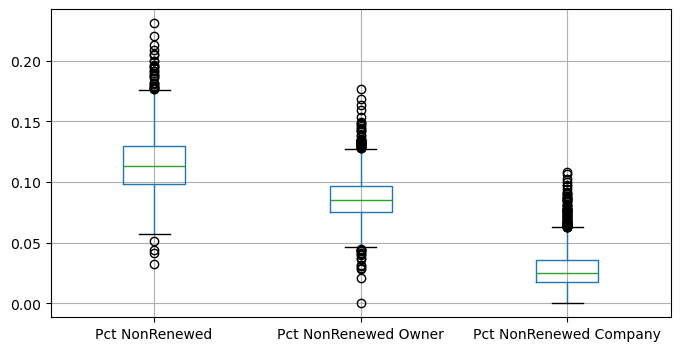

In [54]:
feats = ['Pct NonRenewed', 'Pct NonRenewed Owner', 'Pct NonRenewed Company']

# removing 'extreme' outliers
renewals_flat = renewals_flat[renewals_flat['Pct NonRenewed'] < .3]
renewals_flat = renewals_flat[renewals_flat['Pct NonRenewed Company'] < .12]

renewals_flat[feats].boxplot(figsize=(8,4))

In [55]:
renewals.to_csv(DATA_DIR / 'renewals_yearly.csv')
renewals_flat.to_csv(DATA_DIR / 'renewals_totals.csv')

## FAIR Plan (2022)

The California FAIR Plan provides basic fire insurance coverage for high-risk properties when traditional insurance companies will not. The California FAIR Plan It has recently expanded to offer higher coverage limits of $3 million for residential policyholders and $20 million for commercial policies per location, serving as a safety net for properties that can't obtain coverage in the standard insurance market.

At the zipcode level, we have data for 2022 about residential units with market insurance and FAIR insurance. (The data in available in PDF, but ChatGPT quickly converted to tabular format.)

*** NOTE: There is a better dataset here https://www.cfpnet.com/key-statistics-data/

In [5]:
fair = pd.read_excel(RAW_DATA_DIR / 'full_residential_units_insured_2022.xlsx')

In [6]:
fields = ['ZIP Code', "Voluntary Market Units", "FAIR Plan Units"]
fair = fair[fields]
fair.head()

,ZIP Code,Voluntary Market Units,FAIR Plan Units
0,90001,6913,2104
1,90002,6534,1330
2,90003,8716,1934
3,90004,4710,495
4,90005,996,100


In [7]:
# calculate percentages
fair['Total Ins Units'] = fair['Voluntary Market Units'] + fair['FAIR Plan Units']

fair['Pct Market'] = fair['Voluntary Market Units'] / fair['Total Ins Units']
fair['Pct FAIR'] = fair['FAIR Plan Units'] / fair['Total Ins Units']

fair.sample(3)

,ZIP Code,Voluntary Market Units,FAIR Plan Units,Total Ins Units,Pct Market,Pct FAIR
624,92881,7843,69,7912,0.991279,0.008721
355,92081,6451,14,6465,0.997834,0.002166
157,90810,6372,208,6580,0.968389,0.031611


In [9]:
# remove zipcodes with less the n units
n = 30
fair = fair[fair['Total Ins Units'] > n]

In [10]:
fair.to_csv(DATA_DIR / 'fair_plan2022.csv')

## FAIR Plan 2 (2020-2024)

This dataset contains FAIR Plan information for multiple years (2020-24) as well as information about the total exposure. However, it doesn't include data about the total market policies like the previous dataset.

Also, there are data for residential and commercial policies, but this notebook only deals with residential ones.

In [58]:
# Policies
columns_pol = ['ZIP Code', 
               'growth_23_24', 'policies_24',
               'growth_23_22', 'policies_23',
               'growth_21_22', 'policies_22',
               'growth_22_21', 'policies_21',
               'policies_20']
fair2_pol = pd.read_excel(RAW_DATA_DIR / 'CFP5yearPIFGrowthbyzipcodethrough09302024(Residential+line)20241112v001_unlocked.xlsx', names=columns_pol)

# Exposure
columns_exp = ['ZIP Code', 
               'growth_23_24', 'exposure_24',
               'growth_23_22', 'exposure_23',
               'growth_21_22', 'exposure_22',
               'growth_22_21', 'exposure_21',
               'exposure_20']
fair2_exp = pd.read_excel(RAW_DATA_DIR / 'CFP5yearTIVGrowthbyzipcodethrough09302024(Residentialline)20241112v001_unlocked.xlsx', names=columns_exp)

In [71]:
# removing rows that doesn't contain actual data (totals, etc.)
from pandas.api.types import is_integer, is_number

fair2_pol = fair2_pol[fair2_pol['ZIP Code'].apply(is_integer)].copy()
fair2_exp = fair2_exp[fair2_exp['ZIP Code'].apply(is_integer)].copy()

fair2_pol.shape, fair2_exp.shape

((1647, 10), (1647, 10))

In [60]:
fair2_exp.head(3)

,ZIP Code,growth_23_24,exposure_24,growth_23_22,exposure_23,growth_21_22,exposure_22,growth_22_21,exposure_21,exposure_20
2,94501,0.676,98431342,0.179,58719416,0.137,49797731,0.091,43791971,40143917
3,94502,13.274,6880050,0.025,481983,1.85,470279,0,165000,165000
4,94536,1.995,40642190,0.852,13571624,0.307,7327808,0.264,5605823,4435256


In [61]:
fair2_pol.head(3)

,ZIP Code,growth_23_24,policies_24,growth_23_22,policies_23,growth_21_22,policies_22,growth_22_21,policies_21,policies_20
2,94501,0.333,104,0.04,78,-0.063,75,0,80,80
3,94502,2.5,7,0,2,1,2,0,1,1
4,94536,2.105,59,0.727,19,0.222,11,-0.1,9,10


In [62]:
# merging datasets
fair2 = pd.merge(fair2_pol, fair2_exp, on='ZIP Code')
fair2.head()

,ZIP Code,growth_23_24_x,policies_24,growth_23_22_x,policies_23,growth_21_22_x,policies_22,growth_22_21_x,policies_21,policies_20,growth_23_24_y,exposure_24,growth_23_22_y,exposure_23,growth_21_22_y,exposure_22,growth_22_21_y,exposure_21,exposure_20
0,94501,0.333,104,0.04,78,-0.063,75,0,80,80,0.676,98431342,0.179,58719416,0.137,49797731,0.091,43791971,40143917
1,94502,2.5,7,0,2,1,2,0,1,1,13.274,6880050,0.025,481983,1.85,470279,0,165000,165000
2,94536,2.105,59,0.727,19,0.222,11,-0.1,9,10,1.995,40642190,0.852,13571624,0.307,7327808,0.264,5605823,4435256
3,94538,1.4,24,0.667,10,0.2,6,0.25,5,4,1.445,15574256,1.647,6370385,0.771,2406677,0.352,1358996,1004964
4,94539,2.471,59,1.125,17,1.667,8,-0.25,3,4,1.934,79814473,0.983,27207162,2.696,13722261,-0.094,3712311,4096084


In [63]:
fair2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ZIP Code        1649 non-null   object
 1   growth_23_24_x  1649 non-null   object
 2   policies_24     1649 non-null   object
 3   growth_23_22_x  1649 non-null   object
 4   policies_23     1649 non-null   object
 5   growth_21_22_x  1649 non-null   object
 6   policies_22     1649 non-null   object
 7   growth_22_21_x  1649 non-null   object
 8   policies_21     1649 non-null   object
 9   policies_20     1649 non-null   object
 10  growth_23_24_y  1649 non-null   object
 11  exposure_24     1649 non-null   object
 12  growth_23_22_y  1649 non-null   object
 13  exposure_23     1649 non-null   object
 14  growth_21_22_y  1649 non-null   object
 15  exposure_22     1649 non-null   object
 16  growth_22_21_y  1649 non-null   object
 17  exposure_21     1649 non-null   object
 18  exposure

In [78]:
# convert all columns to float and set to 0 empty values
def clean_non_ints(val):
    return 0 if is_number(val) == False else val

fair2 = fair2.map(clean_non_ints)


In [79]:
fair2.to_csv(DATA_DIR / 'fair_plan.csv')

## Premiums (2018-2023)

California requires insurance companies to report data on their policies every other year for these types of policies: 1.0 (Dwelling Fire), 4.0 (Homeowners), or 12 (EQ only - earthquake?). This dataset provides aggregate data at the zip code level for the 2018-2023 period, including:
- total earned premiums
- total earned exposure (technically, the sum of all claims, but the data doesn't seem to match gradular data on losses)
- fire risk classification
- claims and loss data 

Loss data includes the total amounts of paid losses and number of claims. It's organized in the combination of three categories:
1. Catastrophic/non-catastrophic events
2. Type of Coverage: Coverage A covers only damage to dwelling-unit while Coverage C covers also loss of property.
3. Type of Claim: Smoke or Fire (the only categories included here)


In [28]:
premiums = pd.read_excel(RAW_DATA_DIR / 'Residential-Property-Coverage-Amounts-Wildfire-Risk-and-Losses.xlsx', sheet_name='Cleaned', header=3)
premiums.head()

,Year,Zipcode,Earned Premium,Earned Exposure,Average Cov A,Average Cov C,Average PPC Class,Average Fire Risk,Count Negligible,Count Low,...,Non-Cat Cov C Smoke Claims,Non-Cat Cov C Smoke Losses,Cat Cov A Fire Claims,Cat Cov A Fire Losses,Cat Cov A Smoke Claims,Cat Cov A Smoke Losses,Cat Cov C Fire Claims,Cat Cov C Fire Losses,Cat Cov C Smoke Claims,Cat Cov C Smoke Losses
0,2018,94501,901497,2009,71317.19,53721.01,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1,2018,94502,783059,1633,75639.82,64906.95,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2,2018,94536,1043609,2950,51794.92,32987.53,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
3,2018,94538,738548,2164,49993.05,31687.20,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,2018,94539,573613,1589,59052.51,33615.72,NaN,NaN,NaN,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [29]:
# keep only columns of interest
features = ['Year', 'Zipcode', 'Earned Premium']
premiums = premiums[features]

In [30]:
# removing "Grand total" and "County" rows from the dataset 
premiums = premiums[premiums.Zipcode.apply(type) == int]

# removing annual counts as well
premiums = premiums[premiums.Zipcode > 100]

In [31]:
premiums.rename(columns={'Zipcode': 'ZIP Code'}, inplace=True)

In [32]:
premiums.sample(10)

,Year,ZIP Code,Earned Premium
2501,2018,95864,10036
16980,2019,92405,766238
5936,2018,93529,563451
58865,2022,91501,429626
18762,2019,92880,15846896
57889,2022,95065,19347
14051,2019,94516,11956
713,2018,92840,462640
57061,2022,91390,285016
15212,2019,92122,7040


In [89]:
# Yearly rate of change

premiums_year = pd.pivot_table(premiums, 'Earned Premium', 'ZIP Code', 'Year')
premiums_year.dropna(subset=(2018, 2021), inplace=True)
premiums_year['Pct Change 2018-21'] = (premiums_year[2021] - premiums_year[2018]) / premiums_year[2018]


In [90]:
premiums_year.sample(3)

Year,2018,2019,2020,2021,2022,2023,Pct Change 2018-21
ZIP Code,,,,,,,
92627,1.255556e+06,1.354583e+06,1.550837e+06,1.674337e+06,1.829563e+06,2.014408e+06,0.333543
95117,5.533006e+05,5.863260e+05,6.495063e+05,6.870419e+05,7.338813e+05,7.780399e+05,0.241715
95386,2.160621e+05,2.305627e+05,2.649954e+05,3.330483e+05,3.758138e+05,4.041437e+05,0.541447


In [100]:
# removing outliers

cond1 = premiums_year['Pct Change 2018-21'] < 2
cond2 = premiums_year['Pct Change 2018-21'] > -1

premiums_year = premiums_year[cond1 & cond2]

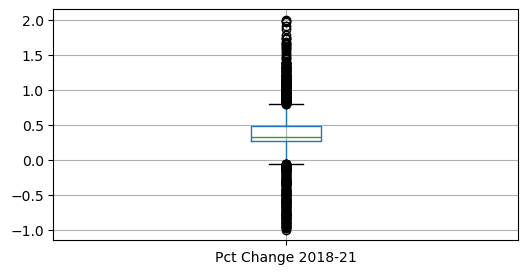

In [104]:
premiums_year[['Pct Change 2018-21']].boxplot(figsize=(6,3))
plt.show()

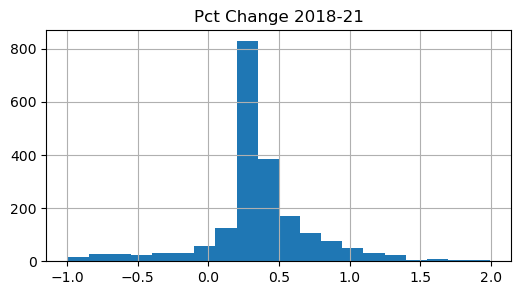

In [105]:
premiums_year[['Pct Change 2018-21']].hist(bins=20, figsize=(6,3))
plt.show()

In [106]:
premiums.to_csv(DATA_DIR / 'premiums_yearly.csv')
premiums_year.to_csv(DATA_DIR / 'premiums_totals.csv')

## FEMA Projected Premium Increases (2021, 2025)

FEMA created a methodology to predict monthly prices increases (Risk Rating 2.0) and publishes zipcode-level data based on it. The data consists of $10-increment columns with number of policies that they predict to change. They also have data for all the policies and for only single-housing units.

https://www.fema.gov/flood-insurance/risk-rating/profiles

In [179]:
fema = pd.read_excel(RAW_DATA_DIR / 'fema_risk-rating-zip-breakdown-california_2021.xlsx', header=3, sheet_name='SFH Zip Count')
fema.tail()

,State,Zip Code,< -$100,$-100 to $-90,$-90 to $-80,$-80 to $-70,$-70 to $-60,$-60 to $-50,$-50 to $-40,$-40 to $-30,...,$20 to $30,$30 to $40,$40 to $50,$50 to $60,$60 to $70,$70 to $80,$80 to $90,$90 to $100,> $100,Grand Total
1456,CA,96161,6.0,1.0,NaN,NaN,2.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0
1457,CA,CA Total of ZIPs w/ <5 Policies,43.0,4.0,4.0,5.0,4.0,7.0,4.0,5.0,...,7.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,562.0
1458,CA,CA Unknown ZIP,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
1459,CA,00052 <5 Policies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,CA Total,NaN,7464.0,814.0,934.0,1277.0,1519.0,1835.0,1977.0,2094.0,...,3132.0,611.0,109.0,46.0,16.0,1.0,7.0,3.0,8.0,165829.0


In [199]:
# removing totals and zipcodes with less than 5 policies
fema = fema[fema['Zip Code'].str.len() == 5]
fema.sample(5)

,State,Zip Code,< -$100,$-100 to $-90,$-90 to $-80,$-80 to $-70,$-70 to $-60,$-60 to $-50,$-50 to $-40,$-40 to $-30,...,$20 to $30,$30 to $40,$40 to $50,$50 to $60,$60 to $70,$70 to $80,$80 to $90,$90 to $100,> $100,Grand Total
308,CA,92020,1.0,1.0,NaN,1.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1196,CA,95554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
804,CA,94025,98.0,4.0,6.0,14.0,13.0,21.0,22.0,22.0,...,12.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662.0
976,CA,94951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
157,CA,91011,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0


In [201]:
fema.to_csv(DATA_DIR / 'premium_change_proj2021.csv')

# DEPRECATED BELOW

# Merging both datasets

In [ ]:
# This will merge only the data between 2018 and 2021, which is the overlap of both datasets.

insurance_df = pd.merge(premiums, renewals, on=['ZIP Code', 'Year'])

In [113]:

insurance_df.to_csv(DATA_DIR / 'insurance.csv')